In [20]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [21]:
df = pd.read_csv('forecasting_data.csv')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

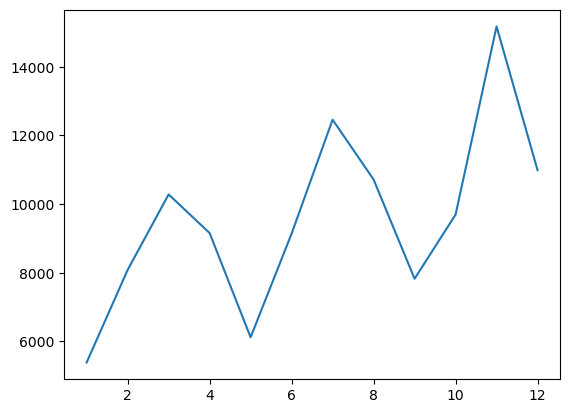

In [22]:
# plot time-series
plt.plot(df['Period'], df['Sales'])
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

C:\Users\user\AppData\Local\Temp\ipykernel_5244\1286820933.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5244\1286820933.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5244\1286820933.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5244\1286820933.py:7: FutureWarning: The frame.append met

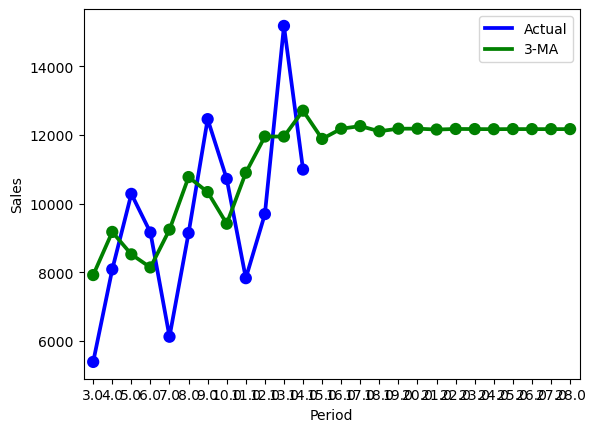

In [23]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for i in range(len(df)-k+1):
        period = df.iloc[i+k-1]['Period']
        sales = df.iloc[i:i+k]['Sales'].mean()
        moving_average_df = moving_average_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
    last_sales = df.iloc[-k:]['Sales'].values
    for i in range(1, to_period+1):
        period = df.iloc[-1]['Period'] + i
        sales = last_sales.mean()
        last_sales = np.append(last_sales[1:], sales)
        moving_average_df = moving_average_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

C:\Users\user\AppData\Local\Temp\ipykernel_5244\26954149.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  es_df = es_df.append({'Period': df.iloc[0]['Period'], 'Sales': df.iloc[0]['Sales']}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5244\26954149.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  es_df = es_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5244\26954149.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  es_df = es_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5244\26954149.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

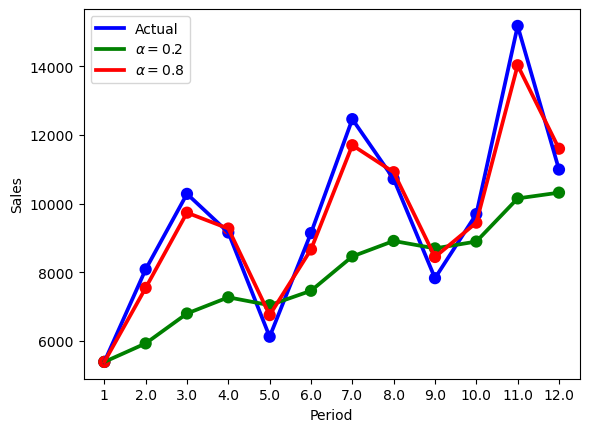

In [24]:
# Using exponential smoothing
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df = es_df.append({'Period': df.iloc[0]['Period'], 'Sales': df.iloc[0]['Sales']}, ignore_index=True)
    for i in range(1, len(df)):
        period = df.iloc[i]['Period']
        sales = alpha * df.iloc[i]['Sales'] + (1 - alpha) * es_df.iloc[-1]['Sales']
        es_df = es_df.append({'Period': period, 'Sales': sales}, ignore_index=True)
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

C:\Users\user\AppData\Local\Temp\ipykernel_5244\249205149.py:44: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


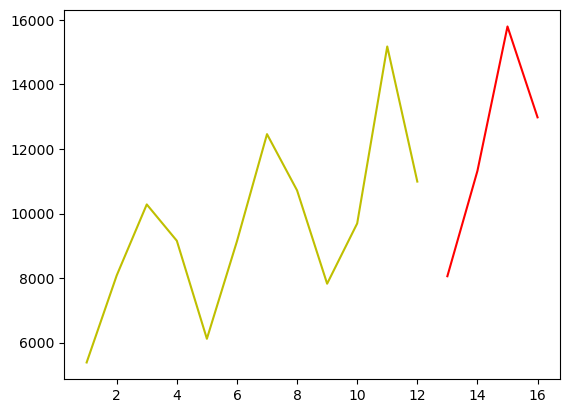

In [25]:
# season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
    
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)

    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)

    avg_df = season_df.mean().to_frame().transpose()
    avg_df.columns = ['I', 'II', 'III']
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df['I'] / avg_df['I'][0]
    seasonal_index_df['II'] = season_df['II'] / avg_df['II'][0]
    seasonal_index_df['III'] = season_df['III'] / avg_df['III'][0]
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1)

    season_df['Avg'] = seasonal_index_df['Avg']
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit.flatten())
    average_predict = poly(4)

    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = season_df['Avg'] * average_predict
    forecast_df['Period'] = np.array(months)
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

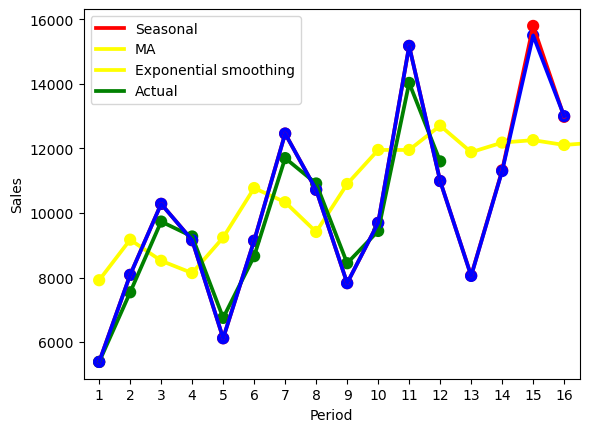

In [26]:

eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [27]:
ma_df['Error'] = abs(ma_df['Sales'] - eval_df['Sales'])
MAD = ma_df['Error'].mean()
print("MAD of {0}: {1}".format("3-MA", MAD))

es_df_02['Error'] = abs(es_df_02['Sales'] - eval_df['Sales'])
MAD = es_df_02['Error'].mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))

es_df_08['Error'] = abs(es_df_08['Sales'] - eval_df['Sales'])
MAD = es_df_08['Error'].mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))

season_df['Error'] = abs(season_df['Sales'] - eval_df['Sales'])
MAD = season_df['Error'].mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2107.187157064472
MAD of Exponential smoothing with alpha=0.2: 1942.508575279786
MAD of Exponential smoothing with alpha=0.8: 490.90977153365293
MAD of Seasonality Method: 85.88221407247443


In [28]:
ma_df['Error'] = ma_df['Sales'] - eval_df['Sales']
MSE = (ma_df['Error'] ** 2).mean()
print("MSE of {0}: {1}".format("3-MA", MSE))

es_df_02['Error'] = es_df_02['Sales'] - eval_df['Sales']
MSE = (es_df_02['Error'] ** 2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))

es_df_08['Error'] = es_df_08['Sales'] - eval_df['Sales']
MSE = (es_df_08['Error'] ** 2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))

season_df['Error'] = season_df['Sales'] - eval_df['Sales']
MSE = (season_df['Error'] ** 2).mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 5316106.963136666
MSE of Exponential smoothing with alpha=0.2: 5870893.334855315
MSE of Exponential smoothing with alpha=0.8: 331335.4158811055
MSE of Seasonality Method: 22206.08964632366
